<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/transfer-learning/Final-ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

TensorFlow 1.x selected.


In [2]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D, Concatenate
import skimage
from skimage.transform import rescale, resize

import pydot

import dlib
import cv2
import random

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.1


In [6]:
EPOCHS = 50
BS = 64
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [7]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output

input2 = Input(shape=(68, 2), name='landmark-in')
x2 = Flatten(name='landmark-flatten')(input2)
x2 = Dense(2048, activation='relu', name='landmark-fc1')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(DROPOUT_RATE)(x2)
x2 = Dense(256, activation='relu', name='landmark-fc2')(x2)
x2 = Dropout(DROPOUT_RATE)(x2)


x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
# l=0
# for layer in vgg_notop.layers:
#     print(layer,"["+str(l)+"]")
#     l=l+1
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
# print('vgg layer 2 is trainable: ' + str(vgg_notop.layers[2].trainable))
# print('vgg layer 3 is trainable: ' + str(vgg_notop.layers[3].trainable))

merged = Concatenate(axis=1)([x, x2])
out = Dense(7, activation='softmax', name='classifier')(merged)

model = Model([vgg_notop.input, input2], out)

optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


94699520/94694792 [==============================] - 1s 0us/step


In [8]:
! rm -rf train
! unzip -q '/content/drive/MyDrive/MINI/Inżynierka/Dane/train.zip'
! rm -rf test
! unzip -q '/content/drive/MyDrive/MINI/Inżynierka/Dane/test.zip'
! rm -rf dev
! unzip -q '/content/drive/MyDrive/MINI/Inżynierka/Dane/dev.zip'

In [9]:
!cp '/content/drive/MyDrive/MINI/Inżynierka/Collab/tensorflow/shape_predictor_68_face_landmarks.dat' '/content'
!cp '/content/drive/MyDrive/MINI/Inżynierka/Collab/tensorflow/haarcascade_frontalface_default.xml' '/content'

In [10]:
import os

def facial_landmarks(image, predictor):
    #image = cv2.imread(filepath)
    face_rects = [dlib.rectangle(left=1, top=1, right=len(image)-1, bottom=len(image)-1)]
    face_landmarks = np.matrix([[p.x, p.y] for p in predictor(image, face_rects[0]).parts()])
    return face_landmarks

def load_filenames(directory):
    emotions_dict = {"anger":0, "disgust":1, "fear":2, "happiness":3, "neutrality":4, "sadness":5, "surprise":6}
    samples = []
    for emotion in emotions_dict:
        path = directory + "/" + emotion
        for file in os.listdir(path):
            if file.endswith(".png"):
                filepath = path + "/" + file
                emotion_label = emotions_dict[emotion]
                samples.append([filepath, emotion_label])
    return samples

def rotate_image(image,deg):
    rows, cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    return image

predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def generator(samples, aug=False, batch_size=BS,shuffle_data=True,resize=Resize_pixelsize):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        random.shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X1 = []
            X2 = []
            y = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_path = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(img_path)
                img = cv2.resize(img,(resize,resize))
                if aug: #augumentations
                    img = rotate_image(img, random.uniform(-5, 5))
                features = facial_landmarks(img, predictor)
                img = img/255

                onehot = [0 for i in range(7)]
                onehot[label] += 1
                
                # apply any kind of preprocessing                
                # Add example to arrays
                X1.append(img)
                X2.append(features)
                y.append(onehot)

            # Make sure they're numpy arrays (as opposed to lists)
            X1 = np.array(X1)
            X2 = np.array(X2)
            y = np.array(y)

            # The generator-y part: yield the next training batch            
            yield [X1, X2], y

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def get_datagen(dataset, aug=False):
#     if aug:
#         datagen = ImageDataGenerator(
#                             rescale=1./255,
#                             featurewise_center=False,
#                             featurewise_std_normalization=False,
#                             rotation_range=10,
#                             width_shift_range=0.1,
#                             height_shift_range=0.1,
#                             zoom_range=0.1,
#                             horizontal_flip=True)
#     else:
#         datagen = ImageDataGenerator(rescale=1./255)
    
#     return datagen.flow_from_directory(
#             dataset,
#             target_size=(197, 197),
#             color_mode='rgb',
#             shuffle = True,
#             class_mode='categorical',
#             batch_size=BS)

In [11]:
samples_train = load_filenames("train")
samples_dev = load_filenames("dev")
samples_test = load_filenames("test")

train_generator  = generator(samples_train, True)
dev_generator    = generator(samples_dev)
test_generator  = generator(samples_test)

In [14]:
# next(train_generator)

In [17]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=32234 // BS,
    validation_steps=490  // BS,
    epochs=30,
    callbacks=[rlrop],
    use_multiprocessing=True
) 

Epoch 1/30
503/503 [==============================] - 496s 987ms/step - loss: 1.2573 - accuracy: 0.5506 - val_loss: 1.2975 - val_accuracy: 0.5089
Epoch 2/30
503/503 [==============================] - 494s 982ms/step - loss: 1.1166 - accuracy: 0.6012 - val_loss: 1.1670 - val_accuracy: 0.5610
Epoch 3/30
503/503 [==============================] - 493s 979ms/step - loss: 1.0329 - accuracy: 0.6266 - val_loss: 1.0765 - val_accuracy: 0.5775
Epoch 4/30
503/503 [==============================] - 493s 981ms/step - loss: 0.9643 - accuracy: 0.6523 - val_loss: 0.9907 - val_accuracy: 0.6174
Epoch 5/30
503/503 [==============================] - 493s 981ms/step - loss: 0.9270 - accuracy: 0.6698 - val_loss: 1.0340 - val_accuracy: 0.6291
Epoch 6/30
503/503 [==============================] - 492s 979ms/step - loss: 0.8846 - accuracy: 0.6818 - val_loss: 0.9071 - val_accuracy: 0.6362
Epoch 7/30
503/503 [==============================] - 492s 979ms/step - loss: 0.8509 - accuracy: 0.6922 - val_loss: 153.4046

In [18]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 490 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.4713708460330963, 0.8727678656578064]


In [19]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 490 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.8717250823974609, 0.6808035969734192]


In [13]:
from google.colab import files
eps = EPOCHS
# eps = 30

epoch_str = '-EPOCHS_' + str(eps)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/MyDrive/MINI/Inżynierka/Collab/tensorflow/' + 'RESNET50-MODYFIKACJA' + epoch_str + test_acc + '.h5')

# files.download('RESNET50-MODYFIKACJA' + epoch_str + test_acc + '.h5')

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


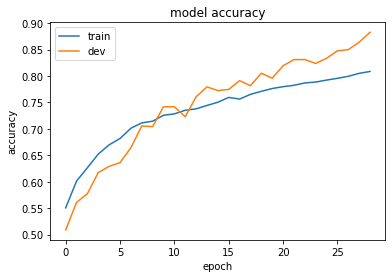

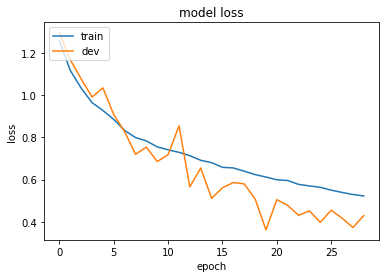

In [36]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'][:6] + history.history['accuracy'][7:])
plt.plot(history.history['val_accuracy'][:6] + history.history['val_accuracy'][7:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.savefig('/content/drive/MyDrive/MINI/Inżynierka/Collab/tensorflow/' + 'RESNET50-MODYFIKACJA' + "-plot_acc" + epoch_str + test_acc + ".png")
plt.show()

# summarize history for loss
plt.plot(history.history['loss'][:6] + history.history['loss'][7:])
plt.plot(history.history['val_loss'][:6]+history.history['val_loss'][7:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.savefig('/content/drive/MyDrive/MINI/Inżynierka/Collab/tensorflow/'+ 'RESNET50-MODYFIKACJA' + "-plot_loss" + epoch_str + test_acc + ".png")
plt.show()

In [37]:
np.save('/content/drive/MyDrive/MINI/Inżynierka/Collab/tensorflow/' + 'RESNET50-MODYFIKACJA' + "-history" + epoch_str + test_acc + ".npy",history.history)

In [22]:
!cp '/content/drive/MyDrive/MINI/Inżynierka/Collab/tensorflow/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5' '/content'

In [27]:
# next(test_generator)

In [24]:
from google.colab import files
from keras.models import load_model

#eps = EPOCHS
eps = 30
# res = 0.549
# res = 0.592
res = 0.681

epoch_str = '-EPOCHS_' + str(eps)
test_acc = 'test_acc_%.3f' % res

#model.save(modelpath)
model = load_model('RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5')


# files.download('RESNET50-MODYFIKACJA' + epoch_str + test_acc + '.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.





In [71]:
%%time

print('\n# Evaluate on test data')
results_test_loaded = model.evaluate_generator(test_generator, 490 // BS)
print('test loss, test acc:', results_test_loaded)


# Evaluate on test data
test loss, test acc: [1.1595714092254639, 0.7042253613471985]
CPU times: user 3min 11s, sys: 1.53 s, total: 3min 12s
Wall time: 49.4 s


In [68]:
%%time

test_generator2 = generator_cut1face(samples_test)

print('\n# Evaluate on test data with face detection')
results_test_loaded_cutface = model.evaluate_generator(test_generator2, 490 // BS)
print('test loss, test acc:', results_test_loaded_cutface)


# Evaluate on test data with face detection
test loss, test acc: [0.6914932727813721, 0.7589285969734192]
CPU times: user 4min 12s, sys: 1.7 s, total: 4min 14s
Wall time: 1min 5s


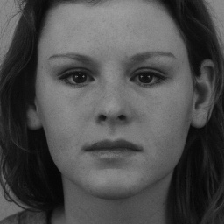

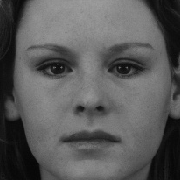

In [62]:
 from google.colab.patches import cv2_imshow

cascPath='haarcascade_frontalface_default.xml'

faceCascade = cv2.CascadeClassifier(cascPath)

imagePath = samples_test[0][0]
# imagePath = '/content/flamingotest.jpg'

image = cv2.imread(imagePath)
# image = cv2.resize(image,(40,40))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# backtocolor = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)


# cv2_imshow(image)
# cv2_imshow(gray)
# cv2_imshow(backtocolor) #backtocolor nadal jest szare wiec gites

faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
)

for (x, y, w, h) in faces:
    #cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    crop = image[y:y+h, x:x+w]

cv2_imshow(image)
cv2_imshow(crop)

In [58]:
faces

array([[ 22,   9, 180, 180]], dtype=int32)

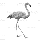

In [46]:
next()

0

In [66]:
import os

def facial_landmarks(image, predictor):
    #image = cv2.imread(filepath)
    face_rects = [dlib.rectangle(left=1, top=1, right=len(image)-1, bottom=len(image)-1)]
    face_landmarks = np.matrix([[p.x, p.y] for p in predictor(image, face_rects[0]).parts()])
    return face_landmarks

def load_filenames(directory):
    emotions_dict = {"anger":0, "disgust":1, "fear":2, "happiness":3, "neutrality":4, "sadness":5, "surprise":6}
    samples = []
    for emotion in emotions_dict:
        path = directory + "/" + emotion
        for file in os.listdir(path):
            if file.endswith(".png"):
                filepath = path + "/" + file
                emotion_label = emotions_dict[emotion]
                samples.append([filepath, emotion_label])
    return samples

def rotate_image(image,deg):
    rows, cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    return image

predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def generator_cut1face(samples, aug=False, batch_size=BS,shuffle_data=True,resize=Resize_pixelsize):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        random.shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X1 = []
            X2 = []
            Y = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_path = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = faceCascade.detectMultiScale(
                    gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(30, 30),
                )
                img = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)

                for (x, y, w, h) in faces:
                    #cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    img = img[y:y+h, x:x+w]

                img = cv2.resize(img,(resize,resize))
                if aug: #augumentations
                    img = rotate_image(img, random.uniform(-5, 5))
                features = facial_landmarks(img, predictor)
                img = img/255

                onehot = [0 for i in range(7)]
                onehot[label] += 1
                
                # apply any kind of preprocessing                
                # Add example to arrays
                X1.append(img)
                X2.append(features)
                Y.append(onehot)

            # Make sure they're numpy arrays (as opposed to lists)
            X1 = np.array(X1)
            X2 = np.array(X2)
            Y = np.array(Y)

            # The generator-y part: yield the next training batch            
            yield [X1, X2], Y